In [1]:
import sys
import os
sys.path.append("../")

import numpy as np
import h5py
import ot
import time
from tqdm import tqdm

import sklearn
from sklearn import svm
from sklearn.manifold import MDS
# from sklearn.cluster import KMeans
import torch
from torch_kmeans import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D


from lib.gromov_barycenter import gw_barycenters,pgw_barycenters
from lib.linear_gromov import LGW_dist,LPGW_embedding,LPGW_dist,LGW_dist,LGW_embedding,lgw_procedure,lpgw_procedure,lmpgw_procedure
from lib.opt import opt_lp,emd_lp
from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

In [2]:
# Adapted from Beier et al: https://github.com/Gorgotha/LGW
def svm_cross_val(dist, X,y, gamma=10, k=10):
    dist_sq=dist
    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)

    dist = dist / dist.max()

    accs = []

    for train_index, test_index in k_folds.split(X, y):
        
        # get train and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up SVM
        kernel_train = np.exp(-gamma * dist[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")
        
        # fit SVM
        clf = svc.fit(kernel_train, y_train)

        kernel_test = np.exp(-gamma * dist_sq[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs.append(acc)

    return accs, np.mean(accs)

In [3]:
label_to_name = {
    '0': 'airplane',
    '1': 'cabinet',
    '2': 'car',
    '3': 'chair',
    '4': 'lamp',
    '5': 'sofa',
    '6': 'table',
    '7': 'watercraft',
    '8': 'bed',
    '9': 'bench',
    '10': 'bookshelf',
    '11': 'bus',
    '12': 'guitar',
    '13': 'motorbike',
    '14': 'pistol',
    '15': 'skateboard',
}

In [4]:
with h5py.File('data/MVP_Train_CP.h5', 'r') as f:
    print(f.keys())
    complete_pcds = f['complete_pcds'][:] # (2400, 2048, 3)
    partial_pcds = f['incomplete_pcds'][:] # (62400, 2048, 3)
    partial_labels = f['labels'][:] # (62400,)

<KeysViewHDF5 ['complete_pcds', 'incomplete_pcds', 'labels']>


In [5]:
# construct the labels for complete shapes
def partial_to_complete_indices(indices,num=26):
    n=indices.shape[0]
    complete_indices=np.zeros(n,dtype=np.int64)
    for (i,idx) in enumerate(indices):
        idx_complete= int(idx/num)
        complete_indices[i]=idx_complete
    indices_unique=np.unique(complete_indices)
    return indices_unique

def complete_to_partial_indices(indices, num=26,size=None):
    if size is None:
        size=num
    n=indices.shape[0]
    partial_indices=[]
    for (i,idx) in enumerate(indices):
        idx_complete= idx*num+np.arange(size)
        partial_indices.append(idx_complete)
    partial_indices=np.concatenate(partial_indices)
    return partial_indices       

complete_indices_all=[]
for i in range(16):
    partial_indices = np.where(partial_labels==i)[0]
    print('Class %i: %i Complete Samples' % (i,partial_indices.shape[0]//26))
    complete_indices=partial_to_complete_indices(partial_indices)
    complete_indices_all.append(complete_indices)

complete_n=(np.concatenate(complete_indices_all)).shape[0]
print('Total: %i'%complete_n)

# construct complete labels
complete_labels=np.zeros(complete_n,dtype=np.int64)
for i,indices in enumerate(complete_indices_all):
    complete_labels[indices]=i
    
# # verify the correctness of the label construction: 
# for i,complete_indices in enumerate(complete_indices_all):
#     complete_indices_2 = np.where(complete_labels==i)[0]
#     print('label %i, error in complete_indices is %0.2f'%(i,np.linalg.norm(complete_indices_2-complete_indices)))
    
#     partial_indices_2=complete_to_partial_indices(complete_indices)
#     partial_indices = np.where(partial_labels==i)[0]
#     print('label %i, error in partial_indices is %0.2f'%(i,np.linalg.norm(partial_indices_2-partial_indices)))

np.savez("data/pcds.npz", complete_pcds=complete_pcds, partial_pcds=partial_pcds, complete_labels=complete_labels, partial_labels=partial_labels)


Class 0: 200 Complete Samples
Class 1: 200 Complete Samples
Class 2: 200 Complete Samples
Class 3: 200 Complete Samples
Class 4: 200 Complete Samples
Class 5: 200 Complete Samples
Class 6: 200 Complete Samples
Class 7: 200 Complete Samples
Class 8: 100 Complete Samples
Class 9: 100 Complete Samples
Class 10: 100 Complete Samples
Class 11: 100 Complete Samples
Class 12: 100 Complete Samples
Class 13: 100 Complete Samples
Class 14: 100 Complete Samples
Class 15: 100 Complete Samples
Total: 2400


In [6]:
data = np.load('data/MVP_train_CP.npz')
ratio = 3 # for each complete shape, we select n incomplete shapes 

complete_pcds = data['complete_pcds'] 
complete_labels = data['complete_labels'] #.astype(np.float64)
sample_size = 10
complete_pcds_sample, partial_pcds_sample, complete_labels_sample, partial_labels_sample = [],[],[],[]

label_list=[0,2,12,15] #[0,1,12,15] # [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for i in label_list:
    complete_indices = np.where(complete_labels==i)[0]
    complete_indices_sample = complete_indices[0:sample_size]
    partial_indices_sample = complete_to_partial_indices(complete_indices_sample,num=26,size=ratio)
    
    complete_pcds_sample.append(complete_pcds[complete_indices_sample])
    complete_labels_sample.append(complete_labels[complete_indices_sample])
    partial_pcds_sample.append(partial_pcds[partial_indices_sample])
    partial_labels_sample.append(partial_labels[partial_indices_sample])
complete_pcds_sample,complete_labels_sample,partial_pcds_sample,partial_labels_sample=np.concatenate(complete_pcds_sample),np.concatenate(complete_labels_sample),np.concatenate(partial_pcds_sample),np.concatenate(partial_labels_sample)



def reduce_point_cloud(point_cloud, n_clusters, device):
    n=point_cloud.shape[1]
    if n_clusters==n:
        return point_cloud

    # Initialize the KMeans algorithm with the desired number of clusters
    kmeans = KMeans(n_clusters=n_clusters).to(device)
    return kmeans(torch.tensor(point_cloud).to(device))
    
    # # The cluster centers are the reduced point cloud
    # reduced_point_cloud = kmeans#.cluster_centers_
    # return reduced_point_cloud


# reduce the size 
size1=1024
size2=768
complete_pcds_sample_1=[]
partial_pcds_sample_1=[]

# for pcd in tqdm(complete_pcds_sample):
#     pcd_1=reduce_point_cloud(pcd,size1)
#     complete_pcds_sample_1.append(pcd_1)
# for pcd in tqdm(partial_pcds_sample):
#     pcd_1=reduce_point_cloud(pcd,size2)
#     partial_pcds_sample_1.append(pcd_1)

complete_pcds_sample_1 = reduce_point_cloud(complete_pcds_sample, size1, 'cuda:0').centers.cpu().numpy()
partial_pcds_sample_1 = reduce_point_cloud(partial_pcds_sample[0:40], size2, 'cuda:1').centers.cpu().numpy()
partial_pcds_sample_2 = reduce_point_cloud(partial_pcds_sample[40:80], size2, 'cuda:2').centers.cpu().numpy()
partial_pcds_sample_3 = reduce_point_cloud(partial_pcds_sample[80:120], size2, 'cuda:3').centers.cpu().numpy()

pcds = list(complete_pcds_sample_1) + list(partial_pcds_sample_1) + list(partial_pcds_sample_2) + list(partial_pcds_sample_3)
partial_pcds_sample_1 = np.concatenate([partial_pcds_sample_1, partial_pcds_sample_2, partial_pcds_sample_3])

np.savez('data/pcds_%i_sample.npz'%size1,complete_pcds_sample=complete_pcds_sample_1,partial_pcds_sample=partial_pcds_sample_1,complete_labels_sample=complete_labels_sample,partial_labels_sample=partial_labels_sample)

# # construct dataset 
# # merge complete_pcds_sample 
# pcds=complete_pcds_sample_1+partial_pcds_sample_1
labels_1=np.concatenate((complete_labels_sample,partial_labels_sample))
labels_2=np.concatenate((np.ones(complete_labels_sample.shape[0]),np.zeros(partial_labels_sample.shape[0])))
labels_2=labels_2.astype(np.int64)

print(len(labels_1))
print(len(pcds))


Full batch converged at iteration 4/100 with center shifts = tensor([3.6653e-06, 3.8303e-06, 1.4760e-06, 1.7842e-06, 6.2843e-06, 4.8088e-06,
        1.9761e-06, 2.8846e-06, 2.9850e-06, 9.2348e-07, 1.3755e-05, 4.0318e-06,
        8.0026e-06, 4.9398e-06, 7.8493e-06, 8.2669e-06, 1.2215e-05, 4.8608e-06,
        9.8087e-06, 2.9201e-06, 1.8565e-06, 5.2778e-06, 5.8107e-06, 1.9310e-06,
        4.6035e-06, 0.0000e+00, 5.0744e-06, 1.3853e-06, 4.6206e-06, 8.6861e-06,
        2.7333e-06, 4.4904e-06, 4.2973e-06, 4.0599e-06, 1.0550e-06, 1.6607e-06,
        1.8309e-06, 4.1704e-06, 4.3383e-06, 1.7448e-06], device='cuda:0').
Full batch converged at iteration 6/100 with center shifts = tensor([0.0000e+00, 3.8376e-06, 3.7680e-06, 6.2232e-06, 0.0000e+00, 2.9798e-06,
        4.3152e-06, 2.1858e-06, 4.2477e-07, 1.7230e-06, 2.3967e-06, 9.9936e-07,
        2.6271e-06, 3.8213e-06, 2.4720e-06, 5.1130e-06, 2.9355e-06, 2.3895e-06,
        3.8183e-06, 5.2066e-07, 1.3919e-06, 4.2966e-06, 3.6686e-06, 1.5426e-06,
   

In [6]:
size1=1024
size2=768
sample_size = 10
label_list=[0,2,12,15]
ratio=3

loaded_data = np.load('data/pcds_%i_sample.npz'%size1)
complete_pcds_sample_1 = loaded_data['complete_pcds_sample']
partial_pcds_sample_1 = loaded_data['partial_pcds_sample']
pcds = list(complete_pcds_sample_1) + list(partial_pcds_sample_1)

complete_labels_sample = loaded_data['complete_labels_sample']
partial_labels_sample = loaded_data['partial_labels_sample']
labels_1=np.concatenate((complete_labels_sample,partial_labels_sample))
len(pcds)

160

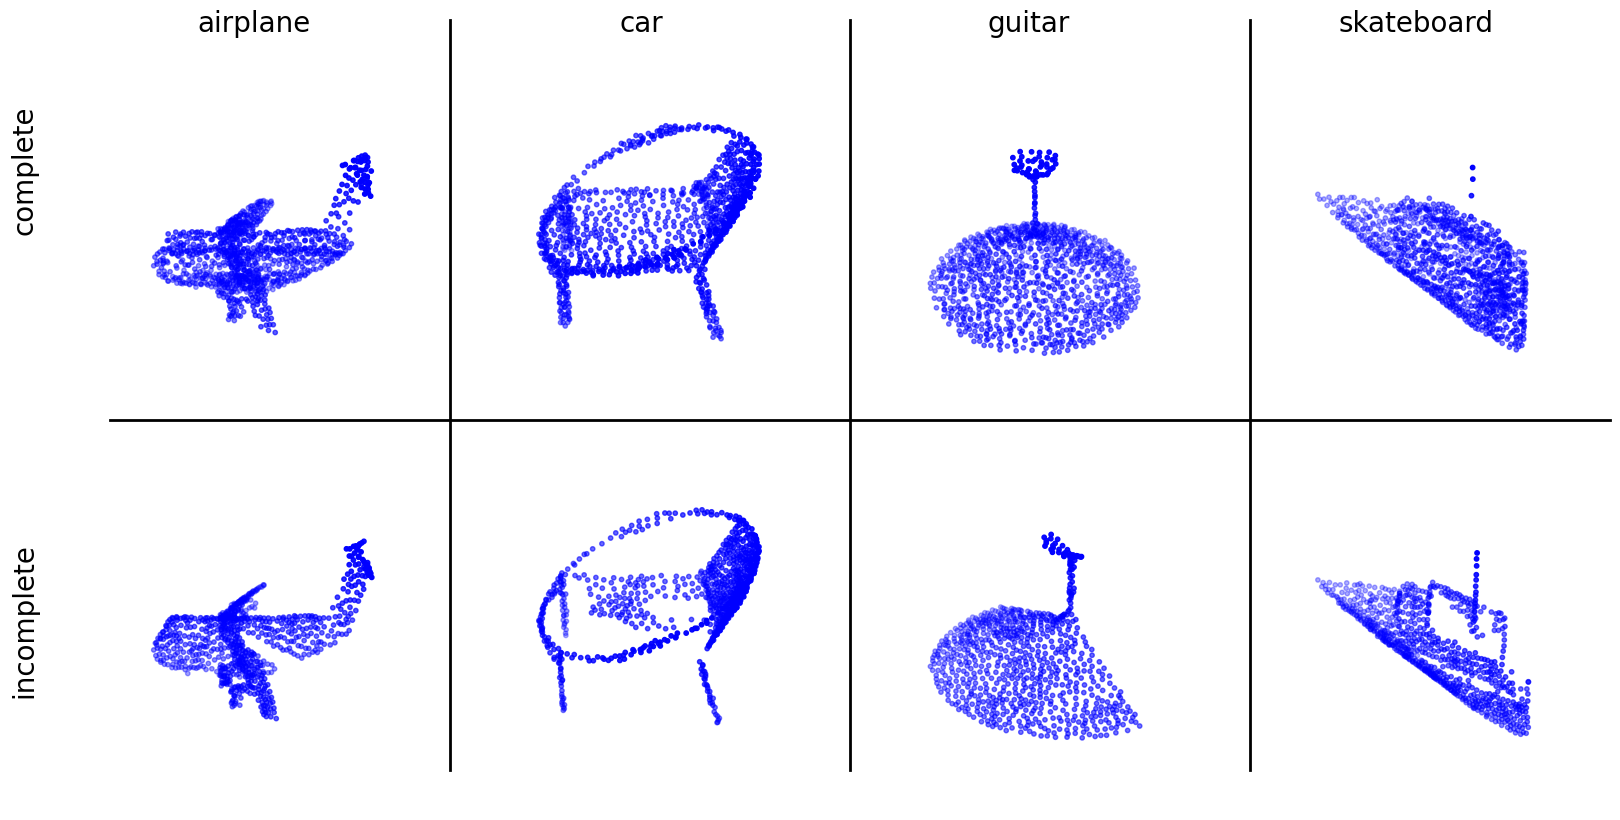

In [7]:
save_path='results_ds'
# Create figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), subplot_kw={'projection': '3d'})


indices = [0, 2, 0, 0]
titles = [label_to_name[str(i)] for i in label_list]


elev_angle_list = [-35,-35,-35,-35]  # Elevation angle
azim_angle_list = [90,90,90,90]  # Azimuth angle

for i,(idx,title,elev_angle,azim_angle) in enumerate(zip(indices,titles,elev_angle_list,azim_angle_list)):
    idx1=i*sample_size+idx
    idx2=sample_size*len(label_list)+i*sample_size*ratio+idx*ratio
    for j,idx3 in enumerate([idx1,idx2]):
        
        ax = axes[j, i]
        ax.scatter(pcds[idx3][:,0], pcds[idx3][:,1],pcds[idx3][:,2],c='b', marker='o',s=10)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        if j==0:
            ax.set_title(title,fontsize=20)
        ax.view_init(elev=elev_angle, azim=azim_angle)
        ax.set_axis_off()
    

# Add vertical text labels on the left side of the first column
fig.text(0.1, 0.75, 'complete', va='center', rotation='vertical', fontsize=20)
fig.text(0.1, 0.3 , 'incomplete', va='center', rotation='vertical', fontsize=20)

# Adjust layout to remove the blank space between subplots
plt.subplots_adjust(wspace=0., hspace=0.)  # Control space between plots

# Add a horizontal line between the two rows
fig.add_artist(plt.Line2D([0.15, .90], [0.5, 0.5], color='black', lw=2, transform=fig.transFigure))
for i in range(3):
    fig.add_artist(plt.Line2D([i/5+0.32, i/5+0.32], [0.15, 0.9], color='black', lw=2, transform=fig.transFigure))
plt.savefig(save_path+"/mvp.png", dpi=300, bbox_inches='tight')
plt.savefig(save_path+"/mvp.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# construct pmf for each shape. 

data=np.load('data/pcds_%i_sample.npz'%size1)

complete_pcds_sample,partial_pcds_sample,complete_labels_sample,partial_labels_sample=data['complete_pcds_sample'],data['partial_pcds_sample'],data['complete_labels_sample'],data['partial_labels_sample']


pcds=[]
for pcd in complete_pcds_sample:
    pcds.append(pcd)
for pcd in partial_pcds_sample:
    pcds.append(pcd)
#np.concatenate((complete_pcds_sample,partial_pcds_sample))
labels_1=np.concatenate((complete_labels_sample,partial_labels_sample))
labels_2=np.concatenate((complete_labels_sample+20,partial_labels_sample))

heights=[]
size_list=np.zeros(len(pcds))
Ms=[]
Lambda_Max=0
M_max=0
for i,pcd in enumerate(pcds):
    n=pcd.shape[0]
    size_list[i]=n
    height=np.ones(n)
    heights.append(height)
    M=np.sqrt(cost_matrix_d(pcd,pcd)).astype(np.float64)
    M_max=max(M.max(),M_max)
    #M=M/M.max()
    #pcd=pcd/M.max()
    Ms.append(M)
    Lambda_Max=max(Lambda_Max,M.max())
alpha=1/np.median(size_list)
heights=[height*alpha for height in heights]

Ms=[M/M_max for M in Ms]
print(heights[0].sum())
print(Ms[1].shape)
print(len(Ms))

1.333333333333333
(1024, 1024)
160


In [10]:
# reference 
import time
numItem=sample_size
idx_bary = [c*numItem for c in range(len(label_list))] #indices of shapes for barycenter computation
n_bary = len(idx_bary)
k_bary = size1
height_ref = np.ones(k_bary)*alpha
ps =[heights[s]/heights[s].sum()*height_ref.sum() for s in idx_bary]
    
st = time.time()   

Cs=[Ms[s] for s in idx_bary] #np.array(Ms,dtype='object')[idx_bary]
Lambda_list=[1.0]*len(idx_bary) #,1.0,1.0,1.0]
Cs=np.array(Cs)
M_ref=np.mean(Cs,0)

height_ref=np.ones(M_ref.shape[0])*alpha

M_ref = pgw_barycenters(k_bary, Cs, ps=ps, p=height_ref, lambdas=ot.unif(n_bary),Lambda_list=Lambda_list, loss_fun='square_loss',
         max_iter=20, tol=1e-5,stop_criterion='barycenter', verbose=False,
        log=False, init_C=None, random_state=0)

# M_ref=ot.gromov.gromov_barycenters(k_bary, Cs = Cs,
#                                             ps = ps, p = height_ref, lambdas = ot.unif(n_bary), loss_fun='square_loss',
#                                             max_iter=10, tol=1e-5,random_state=0,log=False)

et = time.time()



#embedding and plot
# mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
# embedding = mds.fit_transform(M_ref)

#scatter_atomic(embedding, height_ref, n_plots_per_col=1, xmarkers=False, axis_off=True, margin_fac=0.05)

np.savez(save_path+'/reference_%i,%i'%(size1,size2),M_ref=M_ref,height_ref=height_ref)

In [9]:
M_ref=np.load(save_path+'/reference_%i,%i.npz'%(size1,size2))['M_ref']
height_ref=np.load(save_path+'/reference_%i,%i.npz'%(size1,size2))['height_ref']

def normalize_pmf(height,total_mass=False,alpha=1.0/300):
    if total_mass==True:
        return height/height.sum()
    elif total_mass==False:
        return height/height.mean()*alpha

In [12]:
# data=np.load('results/save_%i/reference_%i.npz'%(size1,size1)) 
# M_ref=data['M_ref']
# height_ref=data['height_ref']
# print('M_ref',M_ref.shape)

def normalize_pmf(height,total_mass=False,alpha=1.0/300):
    if total_mass==True:
        return height/height.sum()
    elif total_mass==False:
        return height/height.mean()*alpha


heights_normalized=[height/height.sum() for height in heights]
for (loss_id,loss) in enumerate(['sqrt','square']):
    print('loss is',loss)
    
    X=np.arange(len(Ms))
    if loss_id==0:
        lgw,wall_time,(embeddings,bps)=lgw_procedure(M_ref,height_ref/height_ref.sum(),pcds,Ms,heights_normalized,loss = loss) 
    else:
        lgw,_,(embeddings,bps)=lgw_procedure(M_ref,height_ref/height_ref.sum(),pcds,Ms,heights_normalized,loss = loss,emb=(embeddings,bps))
    lgw=lgw/lgw.max()
    print("LGW computation: " + str(np.round(wall_time,2)) + "s")
    np.savez(save_path+'/lgw_%i_%s'%(size1,loss),dist=lgw,time=wall_time)
    
    accs, mean_acc = svm_cross_val(lgw,X,labels_1,gamma=8)
    print("Mean accuracy for LGW is: ", mean_acc)
    
    # accs, mean_acc = svm_cross_val(lgw,X,labels_2,gamma=8)
    # print("label2, Mean accuracy for LGW is: ", mean_acc)


loss is sqrt
LGW computation: 564.83s
Mean accuracy for LGW is:  0.89375
loss is square
LGW computation: 564.83s
Mean accuracy for LGW is:  0.89375


In [9]:
LAMBDA_MAX=1.0
X=np.arange(len(pcds))

# alpha=1/400
height_ref1 = normalize_pmf(height_ref,alpha=alpha)
heights1 = [normalize_pmf(height,alpha=alpha) for height in heights]

for beta in [0.05, 0.075, 0.1, 0.3, 0.5]:
    for (loss_id,loss) in enumerate(['sqrt']):
        print('Loss:', loss)
        Lambda = beta * LAMBDA_MAX
        print('Lambda:',Lambda)

        if loss_id==0:
            lpgw_trans,lpgw_penalty,(embeddings,bps)=lpgw_procedure(M_ref,height_ref1,pcds,Ms,heights1,Lambda=Lambda,loss = loss)
        # else:
        #     lpgw_trans,_, wall_time,(embeddings,bps)=lpgw_procedure(M_ref,height_ref,pcds,Ms,heights,Lambda=Lambda,loss = loss,emb=(embeddings,bps))
        
        # print("LPGW computation: " + str(np.round(wall_time,2)) + "s")

        # lpgw=np.sqrt(lpgw_trans)
        # lpgw=lpgw/lpgw.max()

        # np.savez(save_path+'/lpgw_%i_%0.3f_%s_1'%(size1,beta,loss),dist=lpgw,time=wall_time)
        # accs, mean_acc = svm_cross_val(lpgw/lpgw.max(),X,labels_1,gamma=8.5)
        # print("lambda is %0.3f, Mean accuracy for LPGW is: "%beta, mean_acc)

        # accs, mean_acc = svm_cross_val(lpgw/lpgw.max(),X,labels_2,gamma=8.5)
        # print("label 2lambda is %0.3f, Mean accuracy for LPGW is: "%beta, mean_acc)
        
        lpgw=np.sqrt(lpgw_trans+lpgw_penalty)
        lpgw=lpgw/lpgw.max()
        
        np.savez(save_path+'/lpgw_%i_%0.3f_%s_2'%(size1,beta,loss),dist=lpgw)
        # accs, mean_acc = svm_cross_val(lpgw/lpgw.max(),X,labels_1,gamma=8.5)

        gammas = [0.01, 0.1, 0.5, 1, 2.5, 5, 10, 100]        
        accs = [svm_cross_val(lpgw/lpgw.max(),X,labels_1,gamma=gamma)[1] for gamma in gammas]

        # print(f"Best Accuracy: {mean_acc} (Gamma = {gammas[np.argmax(accs)]})")
        print(f"Best Accuracy: {np.max(accs)} (Gamma = {gammas[np.argmax(accs)]})")

        # accs, mean_acc = svm_cross_val(lpgw/lpgw.max(),X,labels_2,gamma=8.5)
        # print("label 2,lambda is %0.3f, Mean accuracy for LPGW is: "%beta, mean_acc)


Loss: sqrt
Lambda: 0.05


100%|██████████| 160/160 [37:21<00:00, 14.01s/it]


Best Accuracy: 0.76875 (Gamma = 5)
Loss: sqrt
Lambda: 0.075


100%|██████████| 160/160 [24:13<00:00,  9.09s/it]


In [242]:
LAMBDA_MAX=1.0
X=np.arange(len(pcds))

for beta in [0.7,0.8,0.9]:
    for loss_id,loss in enumerate(['sqrt','square']):
        print('loss is',loss)
        mass = beta * 1.0
        print('mass is',mass)
        height_ref_1=height_ref/height_ref.sum()*(mass)

        if loss_id ==0:
            lmpgw_trans, wall_time,(embeddings,bps)=lmpgw_procedure(M_ref,height_ref_1,pcds,Ms,heights,mass=mass-1e-10,loss = loss)
        else:
            lmpgw_trans, _,(embeddings,Bps)=lmpgw_procedure(M_ref,height_ref*mass,pcds,Ms,heights,mass=mass,loss = loss,emb=(embeddings,bps))
        print("LMPGW computation: " + str(np.round(wall_time,2)) + "s")
        lmpgw=np.sqrt(lmpgw_trans)
        lmpgw=lmpgw/lmpgw.max()
        np.savez('results/lmpgw_%i_%0.3f_%s'%(size1,beta,loss),dist=lmpgw,time=wall_time)
        accs, mean_acc = svm_cross_val(lmpgw/lmpgw.max(),X,labels_1,gamma=5)
        print("mass is %0.3f, Mean accuracy for LMPGW is: "%mass, mean_acc) 

        accs, mean_acc = svm_cross_val(lmpgw/lmpgw.max(),X,labels_2,gamma=5)
        print("label 2, mass is %0.3f, Mean accuracy for LMPGW is: "%mass, mean_acc) 

loss is sqrt
mass is 0.7
LMPGW computation: 335.43s
mass is 0.700, Mean accuracy for LMPGW is:  0.9250000000000002
label 2, mass is 0.700, Mean accuracy for LMPGW is:  0.7124999999999999
loss is square
mass is 0.7
LMPGW computation: 335.43s
mass is 0.700, Mean accuracy for LMPGW is:  0.9250000000000002
label 2, mass is 0.700, Mean accuracy for LMPGW is:  0.7124999999999999
loss is sqrt
mass is 0.8
LMPGW computation: 270.81s
mass is 0.800, Mean accuracy for LMPGW is:  0.9208333333333334
label 2, mass is 0.800, Mean accuracy for LMPGW is:  0.7125
loss is square
mass is 0.8
LMPGW computation: 270.81s
mass is 0.800, Mean accuracy for LMPGW is:  0.9208333333333334
label 2, mass is 0.800, Mean accuracy for LMPGW is:  0.7125
loss is sqrt
mass is 0.9
LMPGW computation: 252.06s
mass is 0.900, Mean accuracy for LMPGW is:  0.9375
label 2, mass is 0.900, Mean accuracy for LMPGW is:  0.7458333333333333
loss is square
mass is 0.9
LMPGW computation: 252.06s
mass is 0.900, Mean accuracy for LMPGW is: 

In [ ]:
from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
def smacof_mds(C, dim, max_iter=3000, eps=1e-9):
    """
    "" This code is imported from PythonOT: Gromov-Wasserstein Barycenter example 
    https://pythonot.github.io/auto_examples/gromov/plot_gromov_barycenter.html
    
    Returns an interpolated point cloud following the dissimilarity matrix C
    using SMACOF multidimensional scaling (MDS) in specific dimensioned
    target space

    Parameters
    ----------
    C : ndarray, shape (ns, ns)
        dissimilarity matrix
    dim : int
          dimension of the targeted space
    max_iter :  int
        Maximum number of iterations of the SMACOF algorithm for a single run
    eps : float
        relative tolerance w.r.t stress to declare converge

    Returns
    -------
    npos : ndarray, shape (R, dim)
           Embedded coordinates of the interpolated point cloud (defined with
           one isometry)
    """

   #rng = np.random.RandomState(seed=3)
    seed=0
    mds = manifold.MDS(
        dim,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity='precomputed',
        normalized_stress='auto',
        n_init=1)
    pos = mds.fit(C).embedding_

    nmds = manifold.MDS(
        2,
        max_iter=max_iter,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=seed,
        normalized_stress='auto',
        n_init=1)
    npos = nmds.fit_transform(C, init=pos)

    return npos
def plot_2d_shape_embedding(data, embedding, min_dist, figsize, cutoff=5, font_size=16, labels=None, save_path=None, col=None, show_numbers=False, padwidth=2, return_img=False, axex=None):
    # Cut outliers
    n_pts = data.shape[0]
    n_dims = data.shape[1]
    low = [np.percentile(embedding[:, 0], q=cutoff), np.percentile(embedding[:, 1], q=cutoff)]
    high = [np.percentile(embedding[:, 0], q=100 - cutoff), np.percentile(embedding[:, 1], q=100 - cutoff)]
    cut_inds = np.arange(n_pts)[(embedding[:, 0] >= low[0]) * (embedding[:, 0] <= high[0])
                                * (embedding[:, 1] >= low[1]) * (embedding[:, 1] <= high[1])]

    data = data[cut_inds, :]
    embedding = embedding[cut_inds, :]

    # Visualize
    fig_x, fig_y = figsize
    fig_ratio = fig_x / fig_y
    #fig = plt.figure(figsize=(fig_x, fig_y))
    #ax = fig.add_subplot(111)

    # Plot images
    img_scale = 0.03
    pixels_per_dimension = int(np.sqrt(n_dims))

    x_size = (max(embedding[:, 0]) - min(embedding[:, 0])) * img_scale
    y_size = (max(embedding[:, 1]) - min(embedding[:, 1])) * img_scale * fig_ratio
    shown_images = np.array([[100., 100.]])

    if labels is not None:
        NUM_COLORS = len(np.unique(labels))
        cm = plt.get_cmap('gist_rainbow')
        unique_labels = np.unique(labels)

    for i in range(n_pts):
        #         dist = np.sqrt(np.sum((embedding[i] - shown_images) ** 2, axis=1))
        # don't show points that are too close
        #         if np.min(dist) < min_dist:
        #             continue
        #         shown_images = np.r_[shown_images, [embedding[i]]]
        x0 = embedding[i, 0] - (x_size / 2.)
        y0 = embedding[i, 1] - (y_size / 2.)
        x1 = embedding[i, 0] + (x_size / 2.)
        y1 = embedding[i, 1] + (y_size / 2.)
        if col is None:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension)
        else:
            img = data[i, :].reshape(pixels_per_dimension, pixels_per_dimension,3)
        #print(np.shape(data[i,:]))
        if labels is not None:
            j = list(unique_labels).index(labels[i])
            col_lab = cm(1.*j/NUM_COLORS)[:3]
            img = np.pad(img.astype(float), (padwidth,padwidth), "constant", constant_values=-1)
            img = np.array([np.array([[x/255,x/255,x/255] if x != -1 else col_lab for x in tmp]) for tmp in img])
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1),cmap="viridiris")
        else:
            axex.imshow(img, aspect='auto', interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
        if show_numbers:
            plt.text(x1, y1, str(i), color="black", fontdict={"fontsize":10,"fontweight":'bold',"ha":"left", "va":"baseline"})


    # scatter plot points
    axex.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=150, alpha=0.5)
    axex.tick_params(axis='both', which='major', labelsize=font_size - 4)

In [ ]:
shape_labels=[]

for i in label_list:
    shape_labels.append(label_to_name[str(i)])
    shape_labels.append(f"incomplete {label_to_name[str(i)]}")

#shape_labels

def plot_dists(dists, labels,shape_labels,size=20):
    fig = plt.figure(figsize=(len(dists) * 6, 6))
    min_val, max_val = 0, 1

    grid = ImageGrid(fig, 111,          
                     nrows_ncols=(1,len(dists)),
                     axes_pad=0.15,
                     share_all=True,
                     cbar_location="right",
                     cbar_mode="single",
                     cbar_size="7%",
                     cbar_pad=0.15,
                     )
    
    x = [size * i for i in range(len(shape_labels))]
    plt.setp(grid, xticks=x, xticklabels=shape_labels, yticks=x, yticklabels=shape_labels)
    
    for data, ax, title in zip(dists, grid, labels):
        data = data/np.max(data)
        im = ax.imshow(data, vmin = min_val, vmax = max_val,cmap = "jet")

        ax.set_title(title, fontsize=24)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=18)
        plt.setp(ax.get_yticklabels(), fontsize=18)
    
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)

# New label order: [1,1,2,2,3,3,4,4] with 40 elements for each label

# Current label order: [1,2,3,4,1,2,3,4] with 20 elements for each label
current_labels =labels_1

    

desired_labels = current_labels.copy()
desired_labels.sort()

def reorder_dist(dist,current_labels,desired_labels):
    n=dist.shape[0]
    # Create the mapping from current label positions to desired positions
    current_to_new_indices = sorted(range(n), key=lambda i: desired_labels.index(current_labels[i]))
    
    # Reorder the matrix according to the new indices
    reordered_matrix = dist[np.ix_(current_to_new_indices, current_to_new_indices)]
    return reordered_matrix

def sub_dist(dist,size=40,selected_label=[0,1,3]):
    induces=np.zeros((len(selected_label)*40),dtype=np.int64)
    for (start,label) in enumerate(selected_label):
        induces[start*size:(start+1)*size]=np.arange(label*size,label*size+size)
    return dist[np.ix_(induces,induces)]
    


size=500
for Lambda,mass in [(0.05,0.9)]:
    lgw=np.load('results/lgw_%i_square.npz'%(size))['dist']
    time=np.load('results/lgw_%i_square.npz'%(size))['time']
    print('time is',time)
    #pgw=np.load('results/save_%i/pgw_%i_%0.1f.npz'%(size,size,Lambda))['dist']
    lpgw=np.load('results/lpgw_%i_%0.3f_square_1.npz'%(size,Lambda))['dist']
    time=np.load('results/lpgw_%i_%0.3f_square_1.npz'%(size,Lambda))['time']
    print('time is',time)

    lmpgw=np.load('results/lmpgw_%i_%0.3f_square.npz'%(size,mass))['dist']
    time=np.load('results/lmpgw_%i_%0.3f_square.npz'%(size,mass))['time']
    print(lmpgw.shape)
    print('time is',time)

    #gw1=reorder_dist(gw,current_labels,desired_labels)
    #gw1=sub_dist(gw1,40,selected_label)
    lgw1=reorder_dist(lgw,current_labels.tolist(),desired_labels.tolist())
    #lgw1=sub_dist(lgw1,40,selected_label)
    
    lpgw1=reorder_dist(lpgw,current_labels.tolist(),desired_labels.tolist())
    lmpgw1=reorder_dist(lmpgw,current_labels.tolist(),desired_labels.tolist())

    #lpgw1=sub_dist(lpgw1,40,selected_label)

    shape_labels1=[]
    for label in label_list:
        shape_labels1.append(label_to_name[str(label)])
        shape_labels1.append('incomplete '+label_to_name[str(label)])
   
    X=np.arange(len(pcds))
    accs, mean_acc1 = svm_cross_val(lgw/lgw.max(),X,labels_1,gamma=15.0)
    print('lgw accuracy is', mean_acc1)

    accs, mean_acc2 = svm_cross_val(lpgw/lpgw.max(),X,labels_1,gamma=15.5)
    print('lpgw accuracy is', mean_acc2)

    
        
    
    plot_dists([lgw1/lgw1.max(),lpgw1/lpgw1.max(),lmpgw1/lmpgw1.max()], 
               [f"LGW",f"LPGW (ours)",f"LMPGW (ours)"],shape_labels=shape_labels1,size=len(pcds)/8)

In [244]:
import time
N=len(Ms)
st = time.time()        
gw = np.zeros((N,N))
for i in range(N):
    M1 = Ms[i].copy()
    height1 = heights[i]
    print(f"\rIteration {i+1}/{N}: Processing...",end='\r')
    for j in range(i+1, N):
        print(f"big loop {i+1}/{N}, small loop {j+1}/{N}: Processing...",end='\r')
        M2 = Ms[j].copy()
        
        height2 = heights[j]
        gamma = gromov_wasserstein(M1, M2, height1/height1.sum(), height2/height2.sum(), G0=None,thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=True)
        gw[i, j] = GW_dist(M1, M2, gamma)

gw += gw.T
gw = np.sqrt(gw)
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")


np.savez('results/gw_%i'%size1,dist=gw,time=et-st)

GW computation: 12216.66ssing.../240: Processing...


In [ ]:
N=len(Ms)
pgw = np.zeros((N,N))
Lambda_MAX=1.0
dist_dic={}
for beta in [0.05,0.1]:
    st = time.time()        
    Lambda = beta * Lambda_MAX
    print('Lambda is',Lambda)
    for i in range(N):
        M1 = Ms[i]
        height1 = heights[i]
    
        for j in range(i+1, N):
            M2 = Ms[j]
            height2 = heights[j]
    
            print(f"big loop {i+1}/{N}, small loop {j+1}/{N}: Processing...",end='\r')
            gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=True)
    
            pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
            pgw[i, j]=pgw_trans+pgw_penalty 
    
    pgw[pgw < 0] = 0
    pgw += pgw.T
    pgw = np.sqrt(pgw)
    et = time.time()
    np.savez('results/pgw_%i_%0.1f'%(size,beta),dist=pgw,time=et-st)
    print('beta is')
    print("PGW computation, beta is {beta}: " + str(np.round(et-st,2)) + "s")


Lambda is 0.05


/home/baly/projects/Linearized_Partial_Gromov_Wasserstein/mvp/../lib/opt.py:243: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


In [ ]:
pcds=pcds.astype(np.float64)
heights_normalized=[height/height.sum() for height in heights]
lgw, wall_time,_=lgw_procedure(M_ref,height_ref/height_ref.sum(),pcds,Ms,heights_normalized,mode = "euclidean")
print("LGW computation: " + str(np.round(wall_time,2)) + "s")
np.savez('results/lgw_%'%size,dist=lgw,time=wall_time)

# LAMBDA_MAX=1.0

for beta in [0.03,0.05,0.1,0.3]:
    Lambda = beta * LAMBDA_MAX
    print('Lambda is',Lambda)
    lpgw, wall_time,(embeddings,Bps)=lpgw_procedure(M_ref,height_ref,pcds,Ms,heights,Lambda=Lambda,mode = "euclidean")
    print('lpgw',lpgw[0,1])
    print("LPGW computation: " + str(np.round(wall_time,2)) + "s")
    np.savez('results/lpgw_%i_%0.3f'%(size,beta),dist=lpgw,time=wall_time)
    accs, mean_acc = svm_cross_val(lpgw,X,labels_1[80:],gamma=5)
    print("lambda is %0.1f, Mean accuracy for LPGW is: "%beta, mean_acc)

In [ ]:
label_list=[0,2,6,8]
shape_labels=[]

for i in label_list:
    shape_labels.append(label_to_name[str(i)])
    shape_labels.append(f"incomplete {label_to_name[str(i)]}")



In [414]:
N=160 #len(partial_pcds_sample)
X=np.arange(160)
size=1000
result=np.load('results/save_%i/gw_%i.npz'%(size,size))
gw,time=result['dist'],result['time']
end=140
accs, mean_acc = svm_cross_val(gw/np.max(gw),X[0:end],labels_1[0:end],gamma=5)
print("Mean accuracy for GW: %0.1f %%"% (mean_acc*100))
print("wall time is %0.2f mins"%(time/60))

result=np.load('results/save_%i/lgw_%i.npz'%(size,size))
lgw,time=result['dist'],result['time']
accs, mean_acc = svm_cross_val(lgw/np.max(lgw),X[0:end],labels_1[0:end],gamma=5)
print("Mean accuracy for LGW: %0.1f %%"%(mean_acc*100))
print("wall time is %0.2f mins"%(time/60))

for beta in [0.1,0.3,0.5]:
    result=np.load('results/save_%i/pgw_%i_%0.1f.npz'%(size,size,beta))
    pgw,time=result['dist'],result['time']
    accs, mean_acc = svm_cross_val(pgw/np.max(pgw),X[0:end],labels_1[0:end],gamma=2)
    print("lambda is %0.1f, Mean accuracy for PGW is %0.1f %% "%(beta, mean_acc*100))
    print("wall time is %0.2f mins"%(time/60))
    

for beta in [0.1,0.3,0.5]:
    result=np.load('results/save_%i/lpgw_%i_%0.1f.npz'%(size,size,beta))
    lpgw,time=result['dist'],result['time']
    accs, mean_acc = svm_cross_val(lpgw/np.max(lpgw),X[0:end],labels_1[0:end],gamma=5)
    print("lambda is %0.1f, Mean accuracy for LPGW is: %0.1f %%"%(beta, mean_acc*100))
    print("wall time is %0.2f mins"%(time/60))

Mean accuracy for GW: 67.9 %
wall time is 127.36 mins
Mean accuracy for LGW: 66.4 %
wall time is 0.86 mins
lambda is 0.1, Mean accuracy for PGW is 84.3 % 
wall time is 244.12 mins
lambda is 0.3, Mean accuracy for PGW is 81.4 % 
wall time is 239.92 mins
lambda is 0.5, Mean accuracy for PGW is 77.1 % 
wall time is 246.33 mins
lambda is 0.1, Mean accuracy for LPGW is: 83.6 %
wall time is 6.89 mins
lambda is 0.3, Mean accuracy for LPGW is: 83.6 %
wall time is 6.78 mins
lambda is 0.5, Mean accuracy for LPGW is: 83.6 %
wall time is 6.37 mins


In [95]:
X=np.arange(N)

result=np.load('results/save/gw_500.npz')
gw=result['dist']
accs, mean_acc = svm_cross_val(gw/np.max(gw),X,partial_labels_sample,gamma=2)
print("Mean accuracy for GW: ", mean_acc)
for beta in [0.2,0.5, 1.0]:
    result=np.load('results/save/pgw_500_%0.1f.npz'%beta)
    pgw=result['dist']
    accs, mean_acc = svm_cross_val(pgw/np.max(pgw),X,partial_labels_sample,gamma=2)
    print("Mean accuracy for PGW: ", mean_acc)





Mean accuracy for GW:  1.0
Mean accuracy for PGW:  0.825
Mean accuracy for PGW:  0.7649999999999999
Mean accuracy for PGW:  0.67


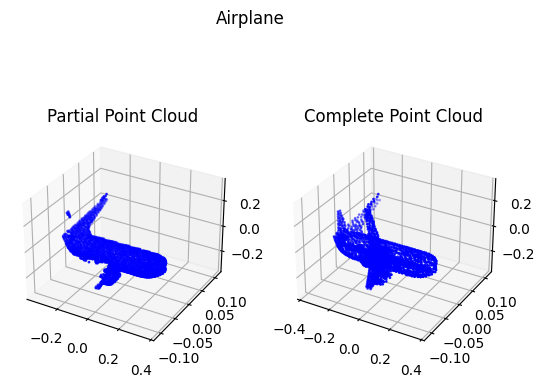

In [52]:
idx = 26
partial = partial_pcds[idx]
complete = complete_pcds[idx // 26]
label = labels[idx]

# Plot partial and complete side by side
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(partial[:, 0], partial[:, 1], partial[:, 2], s=1, c='b', marker='o')
ax1.set_title('Partial Point Cloud')
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(complete[:, 0], complete[:, 1], complete[:, 2], s=1, c='b', marker='o')
ax2.set_title('Complete Point Cloud')
fig.suptitle(label_to_name[str(label)].capitalize())
plt.show()

In [53]:
# Use either /home/public/MVP/MVP_Train_RG.h5 or /home/public/MVP/MVP_Test_RG.h5
with h5py.File('data/MVP_Train_RG.h5', 'r') as f:
    print(f.keys())
    # Source and target are both incomplete point clouds of same model
    src = f['src'][:] # (6400, 2048, 3)
    tgt = f['tgt'][:] # (6400, 2048, 3)
    complete = f['complete'][:] # (2048, 3)
    cat_labels = f['cat_labels'][:] # (6400,)
    
    # Partial point cloud pairs with "match_level = 1" mostly have more correspondences than those with "match_level = 0"
    match_level = f['match_level'][:] # (6400,) 

<KeysViewHDF5 ['cat_labels', 'complete', 'match_id', 'match_level', 'src', 'tgt']>


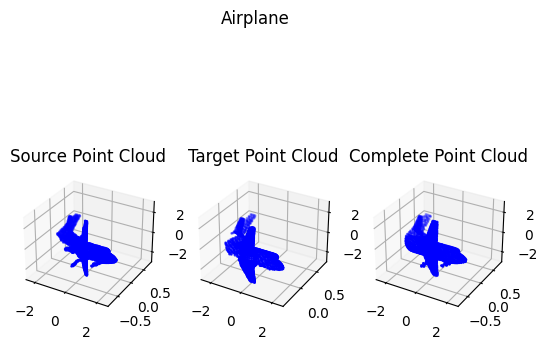

In [54]:
idx = 100
src_pcd = src[idx]
tgt_pcd = tgt[idx]
complete_pcd = complete[idx]
cat_label = cat_labels[idx]

# Plot source, target and complete side by side
fig = plt.figure()
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(src_pcd[:, 0], src_pcd[:, 1], src_pcd[:, 2], s=1, c='b', marker='o')
ax1.set_title('Source Point Cloud')
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(tgt_pcd[:, 0], tgt_pcd[:, 1], tgt_pcd[:, 2], s=1, c='b', marker='o')
ax2.set_title('Target Point Cloud')
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(complete_pcd[:, 0], complete_pcd[:, 1], complete_pcd[:, 2], s=1, c='b', marker='o')
ax3.set_title('Complete Point Cloud')
fig.suptitle(label_to_name[str(cat_label)].capitalize())

plt.show()